In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
! pip install -q keras

ERROR: Operation cancelled by user


In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/dataset'
path_imgs = list(glob.glob(path+'/**/*.jpg'))

In [ ]:
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_imgs))
file_path = pd.Series(path_imgs, name='File_Path').astype(str)
labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,File_Path,Labels
0,/content/drive/MyDrive/Colab Notebooks/dataset...,glaze
1,/content/drive/MyDrive/Colab Notebooks/dataset...,glaze
2,/content/drive/MyDrive/Colab Notebooks/dataset...,frost
3,/content/drive/MyDrive/Colab Notebooks/dataset...,snow
4,/content/drive/MyDrive/Colab Notebooks/dataset...,hail


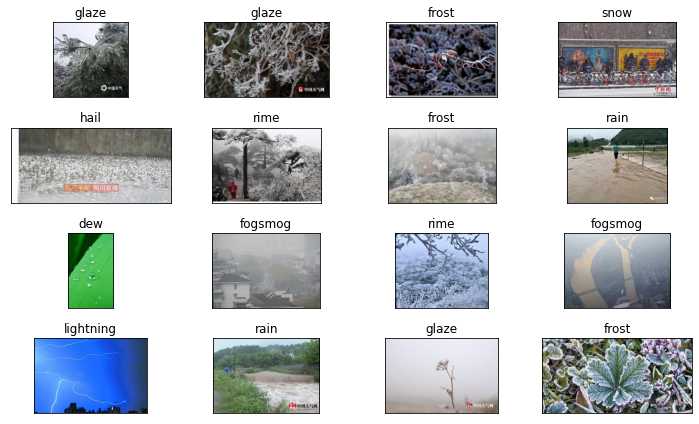

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 6),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Labels[i])
plt.tight_layout()
plt.show()

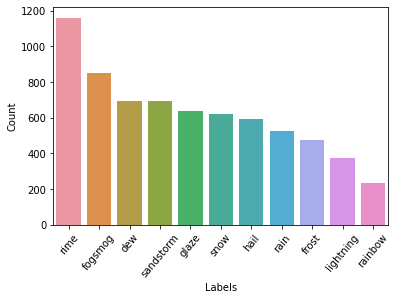

In [ ]:
counts = data.Labels.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=50);

In [ ]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=2)

In [ ]:
def gen(pre,train,test):
    train_datagen = ImageDataGenerator(preprocessing_function=pre, validation_split=0.2)
    test_datagen = ImageDataGenerator(preprocessing_function=pre)
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=32,
        shuffle=False,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        verbose=0,
        shuffle=False)
    return train_gen, valid_gen, test_gen

In [ ]:
def func(name_model):
    pre_model = name_model(input_shape=(100,100, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input
    x = Dense(100, activation='relu')(pre_model.output)
    x = Dense(100, activation='relu')(x)
    outputs = Dense(11, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              mode='auto')]
    return model, my_callbacks

In [ ]:
def plot(history,test_gen,train_gen,model):
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['Train', 'Validation'])
        
    # Predict Data Test
    pred = model.predict(test_gen )
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    
    # Classification report
    cm=confusion_matrix(test_df.Labels,pred)
    clr = classification_report(test_df.Labels, pred)
    print(clr)
    # Display 6 picture of the dataset with their labels
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(test_df.File_Path.iloc[i+1]))
        ax.set_title(f"True: {test_df.Labels.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()
        
    return history

In [ ]:
def result_test(test,model_use):
    results = model_use.evaluate(test, verbose=0)
    
    print("    Test Loss: {:.5f}".format(results[0]))
    print("Test Accuracy: {:.2f}%".format(results[1] * 100))
    
    return results

Found 4388 validated image filenames belonging to 11 classes.
Found 1096 validated image filenames belonging to 11 classes.
Found 1372 validated image filenames belonging to 11 classes.
171458560/171446536 [==============================] - 3s 0us/step
              precision    recall  f1-score   support

         dew       0.94      0.88      0.91       149
     fogsmog       0.83      0.92      0.87       180
       frost       0.78      0.75      0.77        97
       glaze       0.69      0.75      0.72       118
        hail       0.87      0.93      0.90       112
   lightning       1.00      0.87      0.93        83
        rain       0.85      0.73      0.78        82
     rainbow       0.95      0.92      0.93        38
        rime       0.82      0.89      0.85       248
   sandstorm       0.93      0.94      0.94       142
        snow       0.75      0.59      0.66       123

    accuracy                           0.84      1372
   macro avg       0.86      0.84      0.84

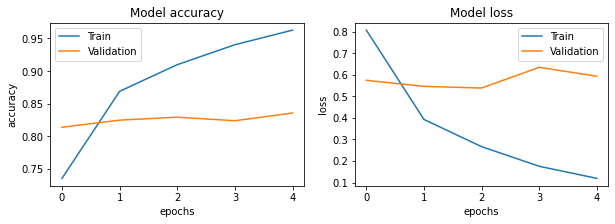

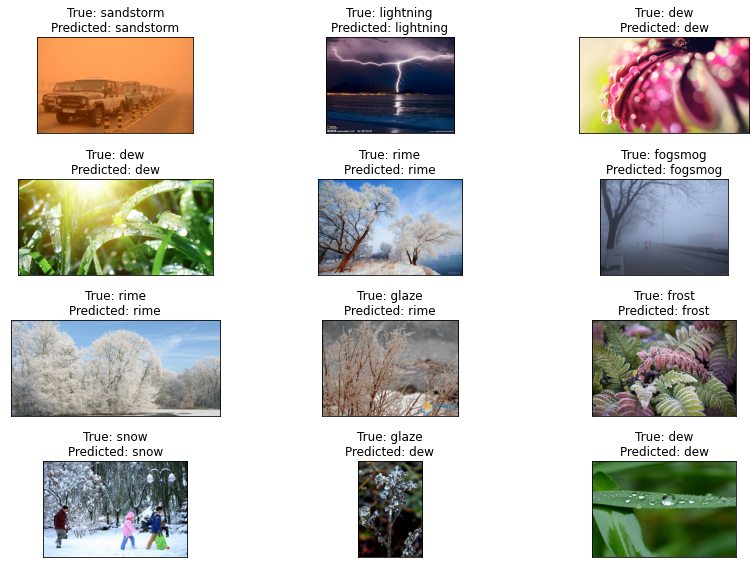

    Test Loss: 0.58389
Test Accuracy: 84.40%


In [ ]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.resnet import preprocess_input

ResNet101_pre=preprocess_input
train_gen_ResNet101, valid_gen_ResNet101, test_gen_ResNet101 = gen(ResNet101_pre,train_df,test_df)
model_ResNet101, callback=func(ResNet101)
history = model_ResNet101.fit(
    train_gen_ResNet101,
    validation_data=valid_gen_ResNet101,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history=plot(history,test_gen_ResNet101,train_gen_ResNet101, model_ResNet101)
result_ResNet101 = result_test(test_gen_ResNet101,model_ResNet101)


Found 4388 validated image filenames belonging to 11 classes.
Found 1096 validated image filenames belonging to 11 classes.
Found 1372 validated image filenames belonging to 11 classes.
74850304/74836368 [==============================] - 1s 0us/step
              precision    recall  f1-score   support

         dew       0.98      0.67      0.80       134
     fogsmog       0.87      0.87      0.87       174
       frost       0.64      0.72      0.68        98
       glaze       0.50      0.88      0.64       131
        hail       0.85      0.92      0.88       109
   lightning       0.94      0.99      0.96        74
        rain       0.84      0.84      0.84        98
     rainbow       0.96      1.00      0.98        43
        rime       0.89      0.71      0.79       232
   sandstorm       0.85      0.91      0.88       142
        snow       0.87      0.57      0.69       137

    accuracy                           0.80      1372
   macro avg       0.83      0.83      0.82  

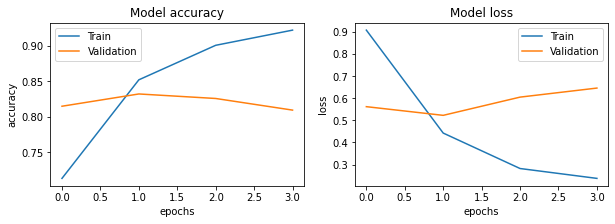

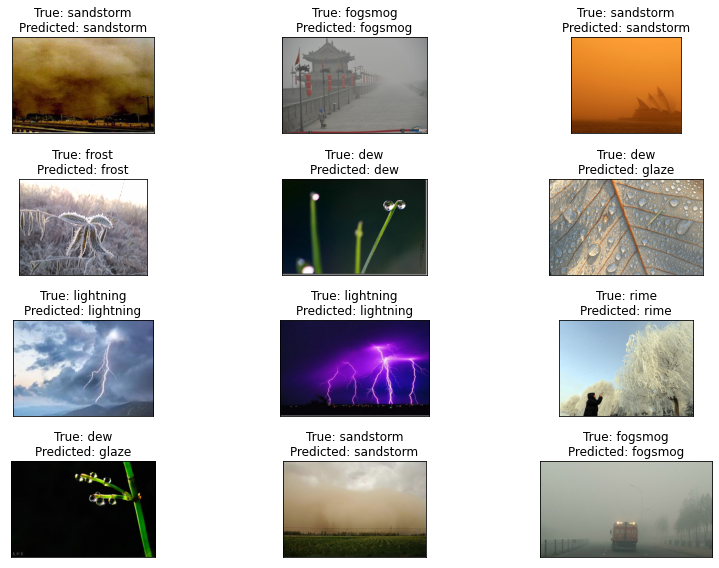

    Test Loss: 0.70497
Test Accuracy: 80.03%


In [ ]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input

DenseNet201_pre=preprocess_input
train_gen_DenseNet201, valid_gen_DenseNet201, test_gen_DenseNet201 = gen(DenseNet201_pre,train_df,test_df)
model_DenseNet201, callback=func(DenseNet201)
history = model_DenseNet201.fit(
    train_gen_DenseNet201,
    validation_data=valid_gen_DenseNet201,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history=plot(history,test_gen_DenseNet201,train_gen_DenseNet201, model_DenseNet201)
result_DenseNet201 = result_test(test_gen_DenseNet201,model_DenseNet201)

Found 4388 validated image filenames belonging to 11 classes.
Found 1096 validated image filenames belonging to 11 classes.
Found 1372 validated image filenames belonging to 11 classes.
83697664/83683744 [==============================] - 1s 0us/step
              precision    recall  f1-score   support

         dew       0.80      0.84      0.82       150
     fogsmog       0.86      0.76      0.81       170
       frost       0.75      0.44      0.56        95
       glaze       0.67      0.73      0.70       136
        hail       0.72      0.90      0.80       103
   lightning       0.94      0.93      0.94        72
        rain       0.87      0.61      0.72       102
     rainbow       0.82      0.92      0.87        51
        rime       0.75      0.84      0.79       215
   sandstorm       0.78      0.83      0.80       141
        snow       0.67      0.70      0.68       137

    accuracy                           0.77      1372
   macro avg       0.79      0.77      0.77  

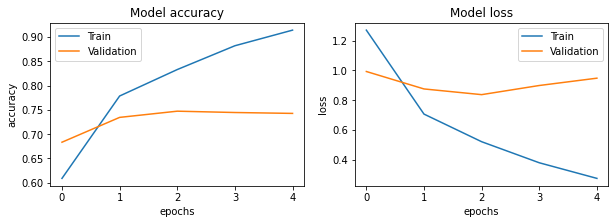

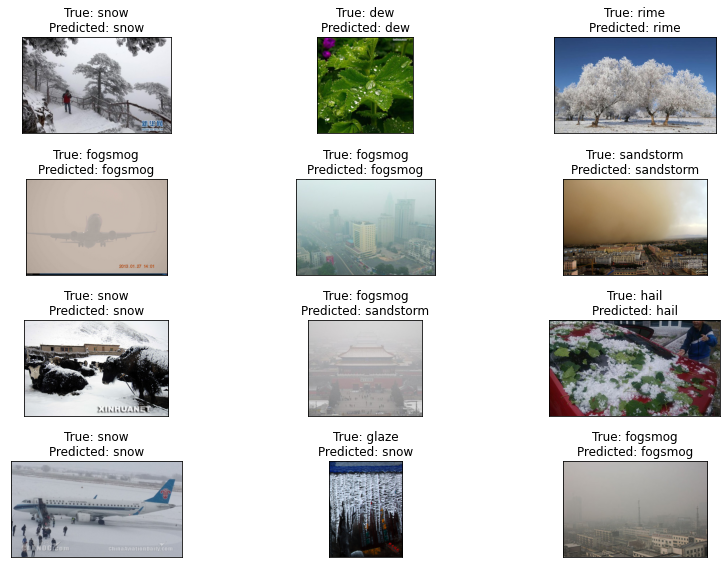

    Test Loss: 0.86222
Test Accuracy: 77.11%


In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
Xception_pre=preprocess_input
train_gen_Xception, valid_gen_Xception, test_gen_Xception = gen(Xception_pre,train_df,test_df)
Xception_model, callback=func(Xception)
history = Xception_model.fit(
    train_gen_Xception,
    validation_data=valid_gen_Xception,
    epochs=100,
    callbacks=callback,
    verbose=0
)
history_Xception = plot(history,test_gen_Xception,train_gen_Xception, Xception_model)
result_Xception = result_tresult_Xception = result_test(test_gen_Xception,Xception_model)